# <h1 style="text-align: center;">Optimal Control of TCLab using a Gaussian process regression embedded in Pyomo - notebook v5b</h1>

<p style="text-align: center;">Alex Dowling<sup>a</sup>, Jacob P. Krell<sup>b</sup>, David S. Mebane<sup>b</sup>

<p style="text-align: center;"><sup>a</sup>Department of Chemical and Biomolecular Engineering, University of Notre Dame, Notre Dame, IN 46556, USA <br>
<sup>b</sup>Department of Mechanical and Aerospace Engineering, West Virginia University, Morgantown, WV, 26506-6106, USA</p>

## Method

- rolling average
- finite-diff.'s gradient
- GP $\propto$ deriv. of control signal (using piecewise values corresponding to analytic)
- fixed-step integration
- apply to step test

## Setup

In [1]:
import os
dir = os.path.abspath('')  # directory of notebook
import pandas as pd
import numpy as np
from FoKL import FoKLRoutines
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

Load and parse data:

In [2]:
data = pd.read_csv(os.path.join(dir, "tclab_sine_test.csv"))

tvec = data["Time"].values
Q1 = data["Q1"].values
TS1 = data["T1"].values

Define heater power control signal:

In [3]:
Q1f = interp1d(tvec, Q1, kind='previous')  # piecewise Q1
dQ1f_analytic = lambda t: 1500 * np.cos(30 * np.pi * t / tvec[-1]) * np.pi / tvec[-1]  # derivative of analytic Q1
dQ1f = interp1d(tvec, dQ1f_analytic(tvec), kind='previous')  # piecewise derivative of analytic Q1

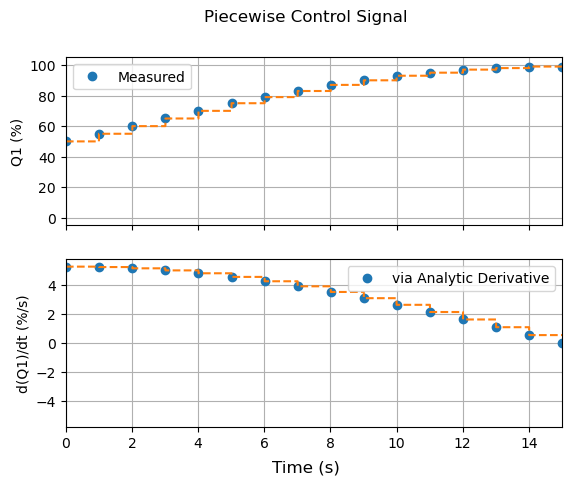

In [4]:
tvec_ub = tvec[1::] - 1e-3  # upper bounds for piecewise plots
tvec_piecewise = [tvec[0]]
for i in range(len(tvec_ub)):
    tvec_piecewise += [tvec_ub[i], tvec[i + 1]]
tvec_piecewise = np.array(tvec_piecewise)

fig, axs = plt.subplots(2, 1, sharex=True)
fig.suptitle("Piecewise Control Signal")
fig.supxlabel("Time (s)")

axs[0].plot(tvec, Q1, 'o')
axs[0].plot(tvec_piecewise, Q1f(tvec_piecewise), '--')
axs[0].set_ylabel("Q1 (%)")
axs[0].set_xlim([0, tvec[-1] / 15 / 4])
axs[0].legend(["Measured"])
axs[0].grid()

axs[1].plot(tvec, dQ1f_analytic(tvec), 'o')
axs[1].plot(tvec_piecewise, dQ1f(tvec_piecewise), '--')
axs[1].set_ylabel("d(Q1)/dt (%/s)")
axs[1].set_xlim([0, tvec[-1] / 15 / 4])
axs[1].legend(["via Analytic Derivative"])
axs[1].grid()

## Benchmark

Predicting temperatures via the two-state ODE,

In [5]:
alpha = 0.00016                                                                     # watts / (units P1 * percent U1)
P1 = 200                                                                            # P1 units
T_amb = TS1[0]  # ambient temperature

IC = [T_amb, T_amb]  # initial condition of states [TH1, TS1]
CpH =  7.006         # J/degC
CpS = 0.01           # J/degC
Ua =  0.051          # W/degC
Ub =  0.001          # W/degC

In [6]:
def dy_benchmark(t, y):
    """Benchmark ODE, for TS1."""
    TH1, TS1 = y
    dTH1 = (Ua * (T_amb - TH1) + Ub * (TS1 - TH1) + alpha * P1 * Q1f(t)) / CpH
    dTS1 = Ub * (TH1 - TS1) / CpS
    return [dTH1, dTS1]

soln_benchmark = solve_ivp(dy_benchmark, [tvec[0], tvec[-1]], IC, t_eval=tvec)

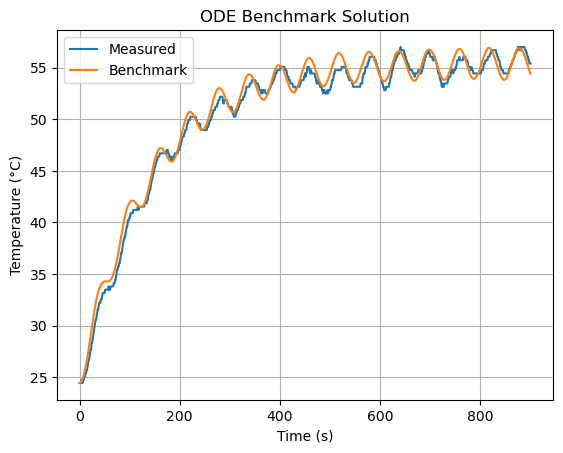

In [7]:
TS1_benchmark = soln_benchmark.y[1]

%matplotlib inline
plt.figure()
plt.plot(tvec, TS1)
plt.plot(tvec, TS1_benchmark)
plt.grid()
plt.title('ODE Benchmark Solution')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
_ = plt.legend(['Measured', 'Benchmark'])

## Derivative of Smoothed Data

Since raw measurements are noisy, a smoothing functions is applied before calculating the time derivative.

### Smoothing

Using a rolling average as the smoothing function,

In [8]:
window = 9  # odd number, mean at center +/- floor(window/2))

In [9]:
def smooth(TS1, window):
    """Apply centered average of size window."""
    TS1_smooth = np.zeros_like(TS1)
    w2 = int(np.floor(window / 2))
    w2p1 = w2 + 1

    # bleed in:
    for i in range(w2):
        TS1_smooth[i] = np.mean(TS1[:(i + w2p1)])

    # center:
    for i in range(w2, TS1_smooth.size - w2):
        TS1_smooth[i] = np.mean(TS1[(i - w2):(i + w2p1)])

    # bleed out:
    for i in range(-w2, 0):
        TS1_smooth[i] = np.mean(TS1[(i - w2)::])

    return TS1_smooth

TS1_smooth = smooth(TS1, window)

### Derivative

In [10]:
def gradient_h4(x, h):
    """h is step size. Order of error is h^4."""
    dx = np.zeros_like(x)

    # bleed in:
    h2 = 2 * h
    dx[0] = (x[1] - x[0]) / h
    dx[1] = (x[2] - x[0]) / h2

    # center difference:
    h12 = 12 * h
    for i in range(2, x.shape[0] - 2):
        dx[i] = (x[i - 2] - 8 * x[i - 1] + 8 * x[i + 1] - x[i + 2]) / h12
    
    # bleed out:
    dx[-2] = (x[-1] - x[-3]) / h2
    dx[-1] = (x[-1] - x[-2]) / h

    return dx

dTS1 = gradient_h4(TS1_smooth, tvec[1] - tvec[0])
dTS1f = interp1d(tvec, dTS1, kind='previous')  # piecewise, grab previous value

Plotting training data:

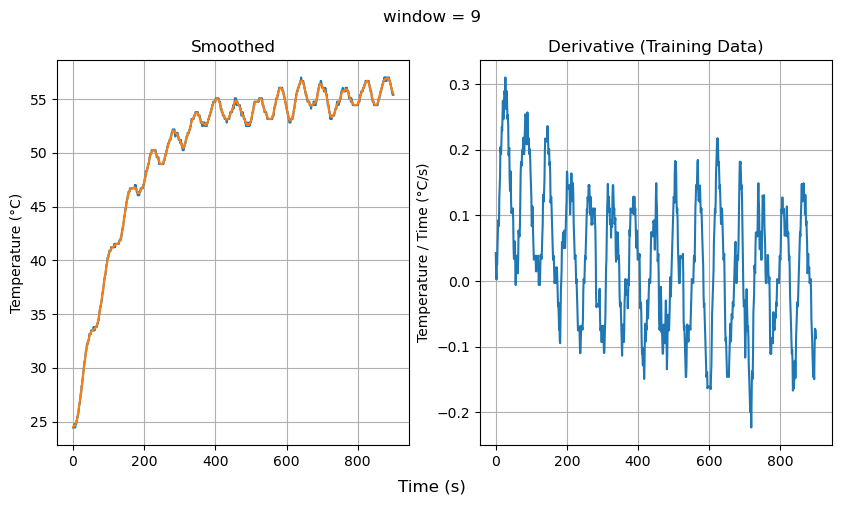

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle(f"window = {window}")
fig.supxlabel("Time (s)")

axs[0].plot(TS1)
axs[0].plot(TS1_smooth)
axs[0].set_title("Smoothed")
axs[0].set_ylabel("Temperature (°C)")
axs[0].grid()

axs[1].plot(dTS1)
axs[1].set_title("Derivative (Training Data)")
axs[1].set_ylabel("Temperature / Time (°C/s)")
axs[1].grid()

Validation of training data:

In [15]:
def dy_training(t, y):
    """ODE to integrate GP's training data'."""
    return [dTS1f(t)]

soln_training = solve_ivp(dy_training, [tvec[0], tvec[-1]], [TS1_smooth[0]], t_eval=tvec, first_step=1, min_step=1, max_step=1)

/home/jacobpatrick/.local/lib/python3.12/site-packages/scipy/integrate/_ivp/ivp.py:621: UserWarning: The following arguments have no effect for a chosen solver: `min_step`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)


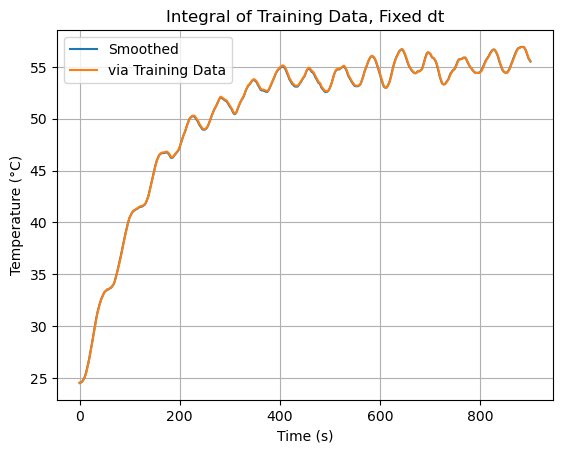

In [17]:
TS1_training = soln_training.y[0]

%matplotlib inline
plt.figure()
plt.plot(tvec, TS1_smooth)
plt.plot(tvec, TS1_training)
plt.grid()
plt.title('Integral of Training Data, fixed dt')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
_ = plt.legend(['Smoothed', 'via Training Data'])

## GP Model of Derivative

In [18]:
GP_dT = FoKLRoutines.FoKL(kernel=1, UserWarnings=False, aic=True)
_ = GP_dT.fit([TS1_smooth, dQ1f(tvec)], dTS1, clean=True)

[1, -4743.770751535981]
[2, -4742.162753192983]
[2, -4788.446617303]
[3, -4799.100762652352]
[3, -4801.96181480126]
[4, -4801.96181480126]
[4, -4801.96181480126]
[4, -4804.41226569077]
[5, -4809.972818670285]
[5, -4811.113075237976]
[5, -4828.874515628349]
[6, -4828.874515628349]
[6, -4833.347561662446]
[6, -4833.347561662446]
[6, -4833.815082013626]
[7, -4844.664928076782]
[7, -4847.25533235577]
[7, -4847.25533235577]
[7, -4851.34746207613]
[8, -4851.34746207613]
[8, -4851.34746207613]
[8, -4861.044092740405]
[8, -4861.044092740405]
[8, -4861.044092740405]
[9, -4861.044092740405]


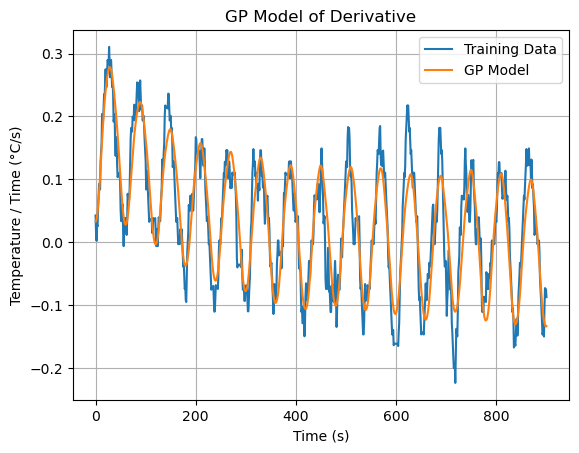

In [19]:
dTS1_GP = GP_dT.evaluate()

%matplotlib inline
plt.figure()
plt.plot(tvec, dTS1)
plt.plot(tvec, dTS1_GP)
plt.title("GP Model of Derivative")
plt.xlabel('Time (s)')
plt.ylabel('Temperature / Time (°C/s)')
plt.legend(['Training Data', 'GP Model'])
plt.grid()

Validation of GP model:

In [21]:
dt = tvec[1] - tvec[0]  # assume constant time step

def dy_GP(t, y):
    """ODE to integrate GP of derivative."""
    return [GP_dT.evaluate([y[0], dQ1f(t)], clean=True, SingleInstance=True)[0]]

soln_GP = solve_ivp(dy_GP, [tvec[0], tvec[-1]], [TS1_smooth[0]], 'LSODA', tvec, first_step=1, min_step=1, max_step=1)

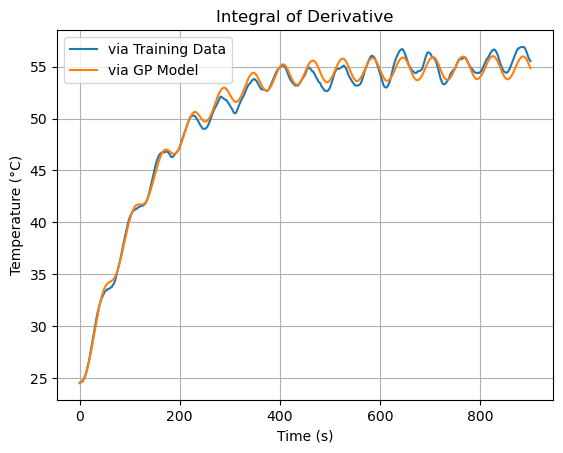

In [24]:
TS1_GP = soln_GP.y[0]

%matplotlib inline
plt.figure()
plt.plot(tvec, TS1_training)
plt.plot(tvec, TS1_GP)
plt.title('Integral of Derivative')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend(['via Training Data', 'via GP Model'])
plt.grid()

## Benchmark Comparison

In [25]:
def _rmse(targets, predictions):
    return np.sqrt(np.mean((predictions - targets) ** 2))

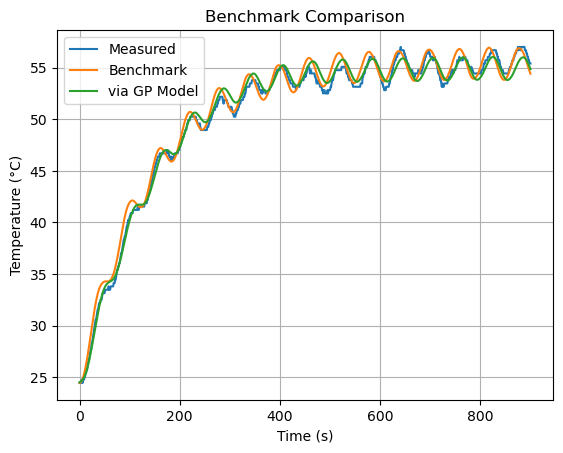

| Method       | RMSE |
|--------------|------|
| Benchmark    | 0.81 |
| via GP Model | 0.62 |


In [30]:
%matplotlib inline
plt.figure()
plt.plot(tvec, TS1)
plt.plot(tvec, TS1_benchmark)
plt.plot(tvec, TS1_GP)
plt.title('Benchmark Comparison')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend(['Measured', 'Benchmark', 'via GP Model'])
plt.grid()
plt.show()

RMSE_benchmark = _rmse(TS1, TS1_benchmark)
RMSE_GP = _rmse(TS1, TS1_GP)

print(f"\
| Method       | RMSE |\n\
|--------------|------|\n\
| Benchmark    | {"{0:0.2f}".format(round(RMSE_benchmark, 2))} |\n\
| via GP Model | {"{0:0.2f}".format(round(RMSE_GP, 2))} |")

## Application of Validated Dynamics $\dot{T} = f(T, \dot{Q})$ to Step Test

### Setup

In [49]:
data_test = pd.read_csv(os.path.join(dir, "tclab_step_test.csv"))

tvec_test = data_test["Time"].values
TS1_test = data_test["T1"].values

### Benchmark

In [50]:
T_amb_test = TS1_test[0]  # ambient temperature
IC_test = [T_amb_test, T_amb_test]  # initial condition of states [TH1, TS1]

In [52]:
def dy_benchmark_test(t, y):
    """Benchmark ODE, for TS1_test."""
    TH1, TS1 = y
    dTH1 = (Ua * (T_amb_test - TH1) + Ub * (TS1 - TH1) + alpha * P1 * 50) / CpH
    dTS1 = Ub * (TH1 - TS1) / CpS
    return [dTH1, dTS1]

soln_benchmark_test = solve_ivp(dy_benchmark_test, [tvec_test[0], tvec_test[-1]], IC_test, t_eval=tvec_test)

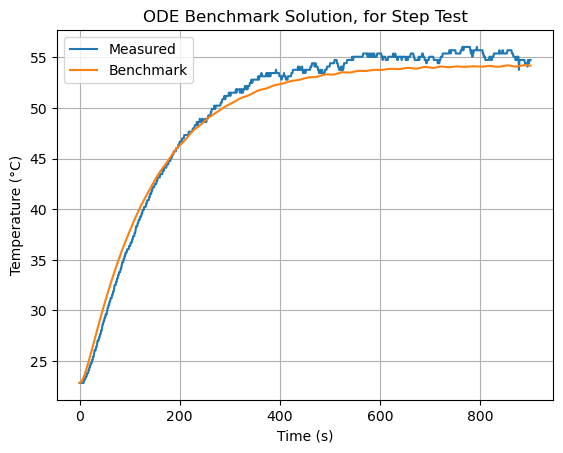

In [53]:
TS1_benchmark_test = soln_benchmark_test.y[1]

%matplotlib inline
plt.figure()
plt.plot(tvec, TS1_test)
plt.plot(tvec, TS1_benchmark_test)
plt.grid()
plt.title('ODE Benchmark Solution, for Step Test')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
_ = plt.legend(['Measured', 'Benchmark'])

### Derivative of Smoothed Data

In [67]:
TS1_test_smooth = smooth(TS1_test, window)

dTS1_test = gradient_h4(TS1_test_smooth, tvec_test[1] - tvec_test[0])
dTS1f_test = interp1d(tvec_test, dTS1_test, kind='previous')  # piecewise, grab previous value

Plot training data:

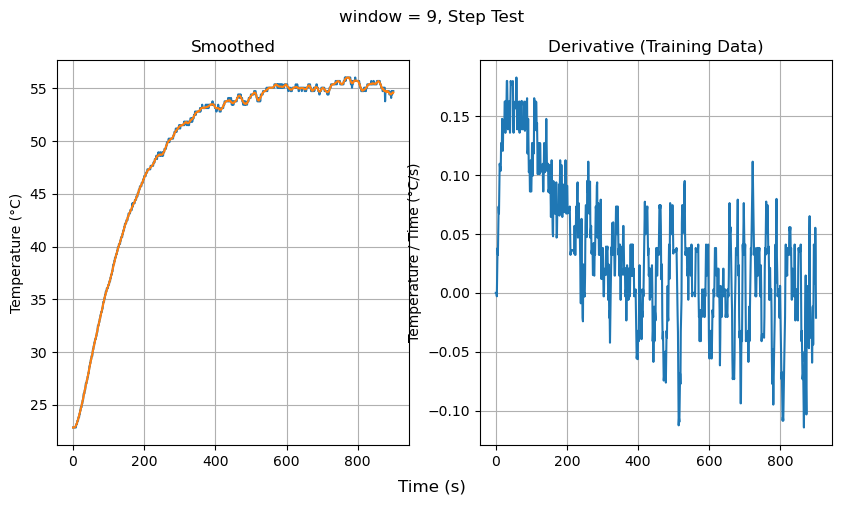

In [68]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle(f"window = {window}, Step Test")
fig.supxlabel("Time (s)")

axs[0].plot(TS1_test)
axs[0].plot(TS1_test_smooth)
axs[0].set_title("Smoothed")
axs[0].set_ylabel("Temperature (°C)")
axs[0].grid()

axs[1].plot(dTS1_test)
axs[1].set_title("Derivative (Training Data)")
axs[1].set_ylabel("Temperature / Time (°C/s)")
axs[1].grid()

Validation of training data:

In [69]:
def dy_training_test(t, y):
    """ODE to integrate GP's training data'."""
    return [dTS1f_test(t)]

soln_training_test = solve_ivp(dy_training_test, [tvec_test[0], tvec_test[-1]], [TS1_test_smooth[0]], t_eval=tvec_test, first_step=1, min_step=1, max_step=1)

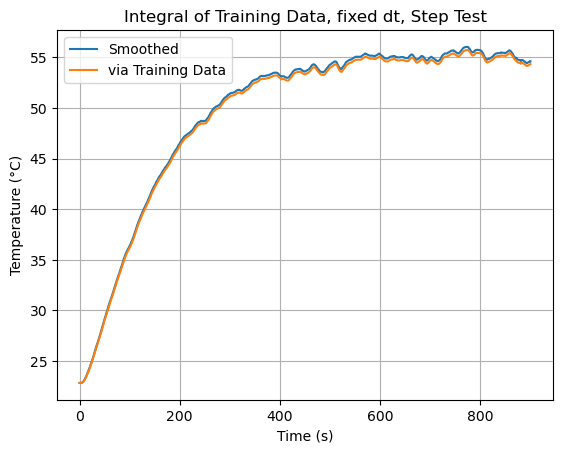

In [70]:
TS1_test_training = soln_training_test.y[0]

%matplotlib inline
plt.figure()
plt.plot(tvec, TS1_test_smooth)
plt.plot(tvec, TS1_test_training)
plt.grid()
plt.title('Integral of Training Data, fixed dt, Step Test')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
_ = plt.legend(['Smoothed', 'via Training Data'])

### GP Model of Derivative

In [71]:
GP_dT_test = FoKLRoutines.FoKL(kernel=1, UserWarnings=False, aic=True)
_ = GP_dT_test.fit(TS1_test_smooth, dTS1_test, clean=True)  # dQ1f_test = const.

[1, -4879.655182506355]
[2, -5018.77935164031]
[3, -5071.574682769873]
[4, -5090.707591185961]
[5, -5109.319647675368]
[6, -5114.268914616823]
[7, -5120.2565333934035]
[8, -5120.2565333934035]
[9, -5120.407996355821]
[10, -5122.989991722487]
[11, -5122.989991722487]
[12, -5121.2893046184645]
[13, -5121.2893046184645]


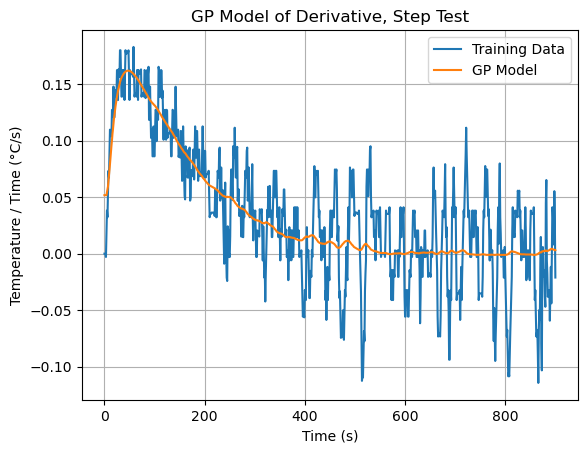

In [72]:
dTS1_test_GP = GP_dT_test.evaluate()

%matplotlib inline
plt.figure()
plt.plot(tvec, dTS1_test)
plt.plot(tvec, dTS1_test_GP)
plt.title("GP Model of Derivative, Step Test")
plt.xlabel('Time (s)')
plt.ylabel('Temperature / Time (°C/s)')
plt.legend(['Training Data', 'GP Model'])
plt.grid()

Validation of GP model:

In [76]:
dt_test = tvec_test[1] - tvec_test[0]  # assume constant time step

def dy_GP_test(t, y):
    """ODE to integrate GP of derivative."""
    return [GP_dT_test.evaluate([y[0]], clean=True, SingleInstance=True)[0]]

soln_GP_test = solve_ivp(dy_GP_test, [tvec_test[0], tvec_test[-1]], [TS1_test_smooth[0]], 'LSODA', tvec_test, first_step=1, min_step=1, max_step=1)

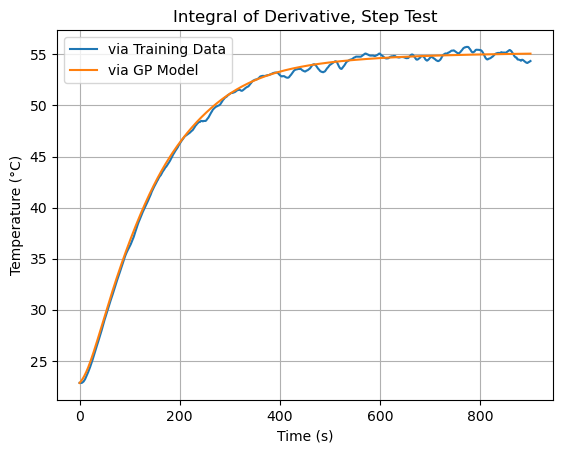

In [77]:
TS1_test_GP = soln_GP_test.y[0]

%matplotlib inline
plt.figure()
plt.plot(tvec, TS1_test_training)
plt.plot(tvec, TS1_test_GP)
plt.title('Integral of Derivative, Step Test')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend(['via Training Data', 'via GP Model'])
plt.grid()

### Benchmark Comparison

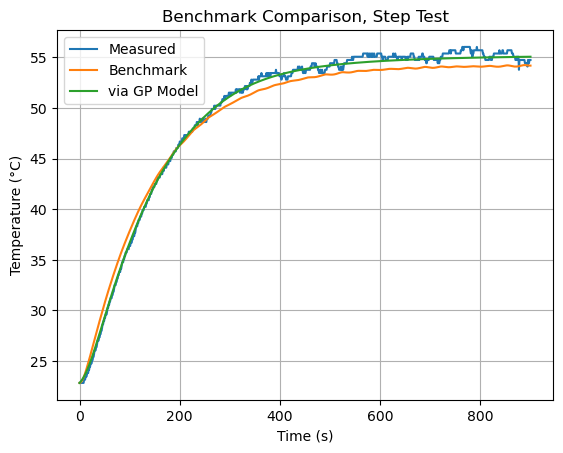

| Method       | RMSE |
|--------------|------|
| Benchmark    | 1.09 |
| via GP Model | 0.39 |


In [78]:
%matplotlib inline
plt.figure()
plt.plot(tvec_test, TS1_test)
plt.plot(tvec_test, TS1_benchmark_test)
plt.plot(tvec_test, TS1_test_GP)
plt.title('Benchmark Comparison, Step Test')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend(['Measured', 'Benchmark', 'via GP Model'])
plt.grid()
plt.show()

RMSE_benchmark_test = _rmse(TS1_test, TS1_benchmark_test)
RMSE_GP_test = _rmse(TS1_test, TS1_test_GP)

print(f"\
| Method       | RMSE |\n\
|--------------|------|\n\
| Benchmark    | {"{0:0.2f}".format(round(RMSE_benchmark_test, 2))} |\n\
| via GP Model | {"{0:0.2f}".format(round(RMSE_GP_test, 2))} |")

## Conclusion

Applying a GP model of the dynamics $\dot{T}_{S,1} = f(T_{S,1},\ \dot{Q}_1)$ from the sine test to data from the step test, the predictions of the step test improve from an RMSE of 1.09 to 0.39.

The sine test itself also improved as expected, but in itself does not show the general application of $\dot{T}_{S,1} = f(T_{S,1},\ \dot{Q}_1)$ to new data.